In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install skforecast

In [3]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
#from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import backtesting_forecaster_intervals

#from joblib import dump, load

In [4]:
p1 = pd.read_csv("data/glucose_01.csv")
p1


,date,time,glucose,type,comments
0,2014-10-01,19:14:00,10.3,cgm,NaN
1,2014-10-01,19:19:00,9.9,cgm,NaN
2,2014-10-01,19:23:00,9.4,manual,NaN
3,2014-10-01,19:24:00,9.8,cgm,NaN
4,2014-10-01,19:29:00,9.6,cgm,NaN
...,...,...,...,...,...
1433,2014-10-06,16:34:02,12.3,cgm,NaN
1434,2014-10-06,16:39:02,12.5,cgm,NaN
1435,2014-10-06,16:44:02,12.5,cgm,NaN
1436,2014-10-06,16:49:02,12.3,cgm,NaN


In [5]:
p1.shape

(1438, 5)

In [6]:
p1.describe()

,glucose,comments
count,1438.000000,0.0
mean,10.194089,NaN
std,4.869156,NaN
min,2.200000,NaN
25%,6.900000,NaN
50%,9.600000,NaN
75%,13.000000,NaN
max,22.200000,NaN


In [7]:
p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1438 non-null   object 
 1   time      1438 non-null   object 
 2   glucose   1438 non-null   float64
 3   type      1438 non-null   object 
 4   comments  0 non-null      float64
dtypes: float64(2), object(3)
memory usage: 56.3+ KB


In [8]:
print(p1.isnull().sum())

date           0
time           0
glucose        0
type           0
comments    1438
dtype: int64


In [9]:
#pasar unidades de mmol/L a mg/dL
p1['glucose'] = p1['glucose'].astype(float)*18.018
#Columna datetime con formato datetime
datetime = p1.date + ' ' + p1.time
p1['datetime'] = pd.to_datetime(datetime, format= '%Y/%m/%d %H:%M:%S', yearfirst=True)
p1

,date,time,glucose,type,comments,datetime
0,2014-10-01,19:14:00,185.5854,cgm,NaN,2014-10-01 19:14:00
1,2014-10-01,19:19:00,178.3782,cgm,NaN,2014-10-01 19:19:00
2,2014-10-01,19:23:00,169.3692,manual,NaN,2014-10-01 19:23:00
3,2014-10-01,19:24:00,176.5764,cgm,NaN,2014-10-01 19:24:00
4,2014-10-01,19:29:00,172.9728,cgm,NaN,2014-10-01 19:29:00
...,...,...,...,...,...,...
1433,2014-10-06,16:34:02,221.6214,cgm,NaN,2014-10-06 16:34:02
1434,2014-10-06,16:39:02,225.2250,cgm,NaN,2014-10-06 16:39:02
1435,2014-10-06,16:44:02,225.2250,cgm,NaN,2014-10-06 16:44:02
1436,2014-10-06,16:49:02,221.6214,cgm,NaN,2014-10-06 16:49:02


In [10]:
# drop duplicates
p1.drop_duplicates(inplace=True)
#Nos quedamos solo con los medidos por cgm
p1 = p1[p1.type=='cgm']
p1

,date,time,glucose,type,comments,datetime
0,2014-10-01,19:14:00,185.5854,cgm,NaN,2014-10-01 19:14:00
1,2014-10-01,19:19:00,178.3782,cgm,NaN,2014-10-01 19:19:00
3,2014-10-01,19:24:00,176.5764,cgm,NaN,2014-10-01 19:24:00
4,2014-10-01,19:29:00,172.9728,cgm,NaN,2014-10-01 19:29:00
5,2014-10-01,19:34:00,169.3692,cgm,NaN,2014-10-01 19:34:00
...,...,...,...,...,...,...
1433,2014-10-06,16:34:02,221.6214,cgm,NaN,2014-10-06 16:34:02
1434,2014-10-06,16:39:02,225.2250,cgm,NaN,2014-10-06 16:39:02
1435,2014-10-06,16:44:02,225.2250,cgm,NaN,2014-10-06 16:44:02
1436,2014-10-06,16:49:02,221.6214,cgm,NaN,2014-10-06 16:49:02


<AxesSubplot:xlabel='datetime', ylabel='glucose'>

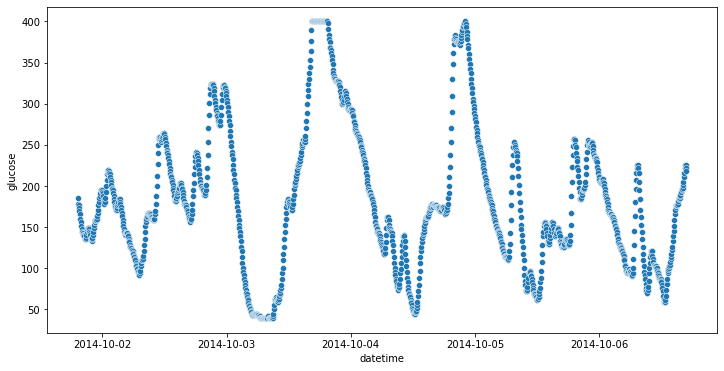

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(p1.datetime, p1.glucose)

<AxesSubplot:xlabel='datetime', ylabel='glucose'>

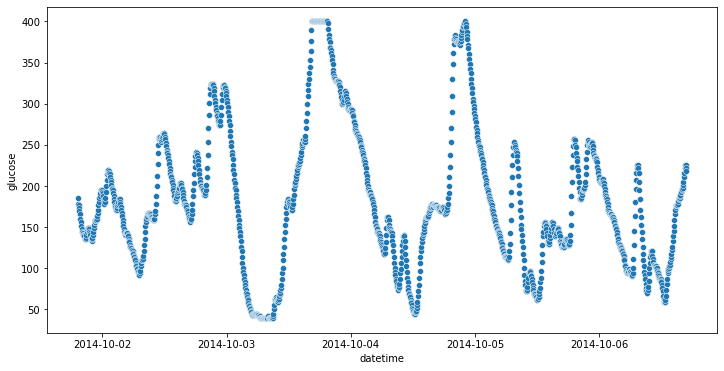

In [12]:
datos = p1.set_index('datetime')
datos = datos.asfreq(freq='5min', method="bfill")
datos = datos[['glucose']]
datos = datos.sort_index()
plt.figure(figsize=(12, 6))
sns.scatterplot(datos.index, datos.glucose)

In [13]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

# ML

In [14]:
datos = datos[['glucose']]

In [15]:
# Seasonal features: We will add daily and two days season
# sin(2*pi*x/period)
for period in [24,24*2]:
    datos[f"s-{period}"]=np.sin(2*np.pi*np.arange(len(datos))/period)
    datos[f"c-{period}"]=np.cos(2*np.pi*np.arange(len(datos))/period)
datos

,glucose,s-24,c-24,s-48,c-48
datetime,,,,,
2014-10-01 19:14:00,185.5854,0.000000,1.000000e+00,0.000000,1.000000
2014-10-01 19:19:00,178.3782,0.258819,9.659258e-01,0.130526,0.991445
2014-10-01 19:24:00,176.5764,0.500000,8.660254e-01,0.258819,0.965926
2014-10-01 19:29:00,172.9728,0.707107,7.071068e-01,0.382683,0.923880
2014-10-01 19:34:00,169.3692,0.866025,5.000000e-01,0.500000,0.866025
...,...,...,...,...,...
2014-10-06 16:34:00,221.6214,-0.866025,-5.000000e-01,0.866025,-0.500000
2014-10-06 16:39:00,225.2250,-0.965926,-2.588190e-01,0.793353,-0.608761
2014-10-06 16:44:00,225.2250,-1.000000,-1.616596e-14,0.707107,-0.707107


In [16]:
datos.columns

Index(['glucose', 's-24', 'c-24', 's-48', 'c-48'], dtype='object')

In [17]:
X = datos[['s-24', 'c-24', 's-48', 'c-48']]
y = datos['glucose']

In [18]:
# Minimum Datetime
datos.index.min()

Timestamp('2014-10-01 19:14:00', freq='5T')

In [19]:
# Minimum Datetime
datos.index.max()

Timestamp('2014-10-06 16:54:00', freq='5T')

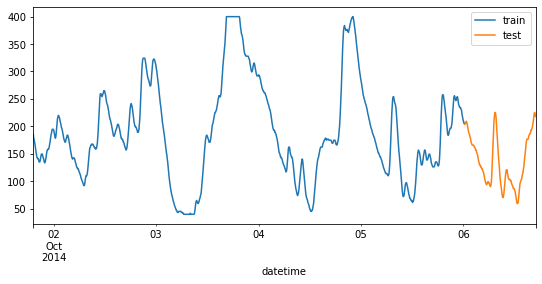

In [20]:
# Separación datos train-test
# ==============================================================================
steps = 200
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
datos_train['glucose'].plot(ax=ax, label='train')
datos_test['glucose'].plot(ax=ax, label='test')
ax.legend();

In [21]:
# Train / Test possibility 1
# We take last 1 day (24)
# !!!!!!! Gridsearch (and cross_val) in sklearn uses POSITIONAL index, not dataframe index
steps=200
train_index = np.arange(len(X.index))[:-steps]
test_index = np.arange(len(X.index))[-steps:]

In [22]:
reg_gd = GridSearchCV(DecisionTreeRegressor(),
                      param_grid={"max_depth":np.arange(2,11),
                                  "min_samples_leaf":np.arange(10,100,15)},
                      scoring="neg_mean_absolute_error",
                      cv=[(train_index,test_index)])
reg_gd.fit(X,y)

GridSearchCV(cv=[(array([   0,    1,    2, ..., 1210, 1211, 1212]),
                  array([1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223,
       1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234,
       1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245,
       1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256,
       1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267,
       1268, 1269, 1270, 1...
       1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377,
       1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388,
       1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399,
       1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410,
       1411, 1412]))],
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_leaf': array([10, 25, 40, 55, 70, 8

In [23]:
reg_gd.best_params_


{'max_depth': 3, 'min_samples_leaf': 25}

In [24]:
reg_gd.best_score_

-59.7091697408331

In [25]:
X = datos_test[['s-24', 'c-24', 's-48', 'c-48']]
y = datos_test['glucose']

Random Forest

In [26]:
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
regressor.fit(X,y)

RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

In [27]:
steps = 36
predicciones = regressor.predict(X)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

datetime
2014-10-06 00:19:00    148.287997
2014-10-06 00:24:00    145.891742
2014-10-06 00:29:00    144.266531
2014-10-06 00:34:00    143.113099
2014-10-06 00:39:00    144.189619
Freq: 5T, dtype: float64

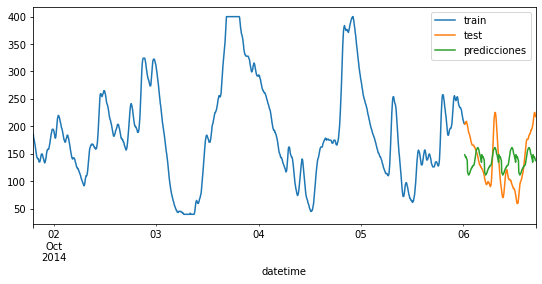

In [28]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['glucose'].plot(ax=ax, label='train')
datos_test['glucose'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

**Series temporales**

In [29]:
df_g = p1.set_index('datetime')
df_g = df_g.asfreq(freq='5min', method="bfill")
df_g = df_g[['glucose']]
df_g = df_g.sort_index()
df_g

,glucose
datetime,
2014-10-01 19:14:00,185.5854
2014-10-01 19:19:00,178.3782
2014-10-01 19:24:00,176.5764
2014-10-01 19:29:00,172.9728
2014-10-01 19:34:00,169.3692
...,...
2014-10-06 16:34:00,221.6214
2014-10-06 16:39:00,225.2250
2014-10-06 16:44:00,225.2250


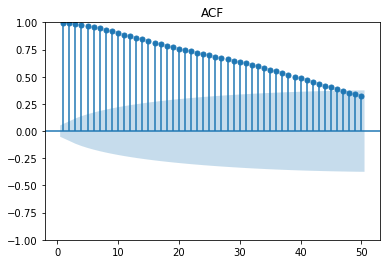

In [30]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(df_g, lags=50, zero=False)
plt.title("ACF")
plt.show()

In [31]:
df_g['lag10'] = df_g['glucose'].shift(10)
df_g['lag11'] = df_g['glucose'].shift(11)
df_g['lag12'] = df_g['glucose'].shift(12)
df_g['lag30'] = df_g['glucose'].shift(30)
df_g['lag35'] = df_g['glucose'].shift(35)
df_g.dropna(inplace=True)
df_g.head()

,glucose,lag10,lag11,lag12,lag30,lag35
datetime,,,,,,
2014-10-01 22:09:00,140.5404,149.5494,149.5494,149.5494,165.7656,185.5854
2014-10-01 22:14:00,144.1440,147.7476,149.5494,149.5494,160.3602,178.3782
2014-10-01 22:19:00,149.5494,144.1440,147.7476,149.5494,156.7566,176.5764
2014-10-01 22:24:00,153.1530,142.3422,144.1440,147.7476,151.3512,172.9728
2014-10-01 22:29:00,156.7566,140.5404,142.3422,144.1440,147.7476,169.3692


In [32]:
df_g.columns

Index(['glucose', 'lag10', 'lag11', 'lag12', 'lag30', 'lag35'], dtype='object')

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = df_g[['lag10', 'lag11', 'lag12', 'lag30', 'lag35']], df_g['glucose']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [34]:
scaler = StandardScaler()
Scaled_train = scaler.fit_transform(X_train)

Scaled_test = scaler.transform(X_test)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [36]:
reg = RandomForestRegressor(max_depth=10, random_state=0)
reg.fit(Scaled_train,y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [37]:
predictions_rf = reg.predict(Scaled_test)

In [38]:
results = pd.DataFrame(y_test)
results['predictions_rf'] = predictions_rf
results.head()

,glucose,predictions_rf
datetime,,
2014-10-03 23:54:00,291.8916,291.213388
2014-10-04 08:29:00,100.9008,133.756638
2014-10-06 03:59:00,127.9278,135.401420
2014-10-05 21:34:00,232.4322,271.043312
2014-10-04 00:19:00,288.2880,287.470892


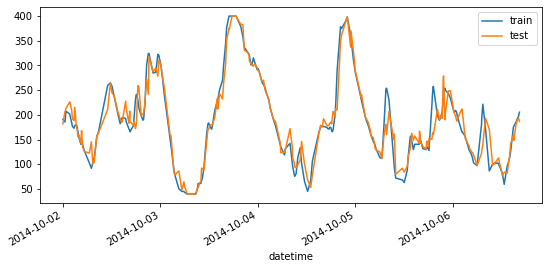

In [39]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
results['glucose'].plot(ax=ax, label='train')
results['predictions_rf'].plot(ax=ax, label='test')
ax.legend();

In [40]:
from sklearn.metrics import mean_squared_error

rmse_rf = mean_squared_error(y_test, predictions_rf, squared=False)

In [41]:
results['rmse_rf'] = rmse_rf
results.head()

,glucose,predictions_rf,rmse_rf
datetime,,,
2014-10-03 23:54:00,291.8916,291.213388,25.097003
2014-10-04 08:29:00,100.9008,133.756638,25.097003
2014-10-06 03:59:00,127.9278,135.401420,25.097003
2014-10-05 21:34:00,232.4322,271.043312,25.097003
2014-10-04 00:19:00,288.2880,287.470892,25.097003


<AxesSubplot:>

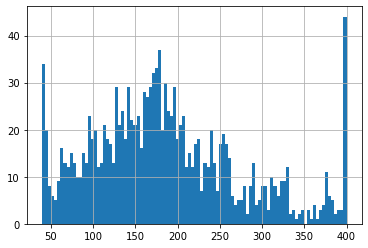

In [42]:
df_g['glucose'].hist(bins=100)

<AxesSubplot:xlabel='glucose', ylabel='Density'>

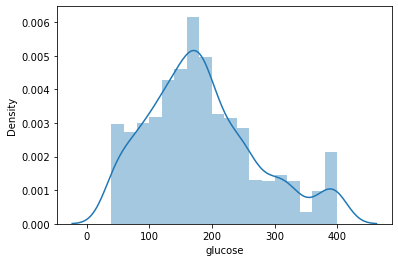

In [43]:
sns.distplot(df_g['glucose'])

Linear Regression


In [44]:
from sklearn.linear_model import LinearRegression
modelo = LinearRegression()
modelo.fit(Scaled_train, y_train)

LinearRegression()

In [45]:
predictions_rl = modelo.predict(Scaled_test)

In [46]:
results['predictions_rl'] = predictions_rl
rmse_rl = mean_squared_error(y_test, predictions_rl, squared=False)
results['rmse_rl'] = rmse_rl
results.head()

,glucose,predictions_rf,rmse_rf,predictions_rl,rmse_rl
datetime,,,,,
2014-10-03 23:54:00,291.8916,291.213388,25.097003,286.488210,30.810814
2014-10-04 08:29:00,100.9008,133.756638,25.097003,136.701733,30.810814
2014-10-06 03:59:00,127.9278,135.401420,25.097003,147.087809,30.810814
2014-10-05 21:34:00,232.4322,271.043312,25.097003,237.082073,30.810814
2014-10-04 00:19:00,288.2880,287.470892,25.097003,265.000212,30.810814


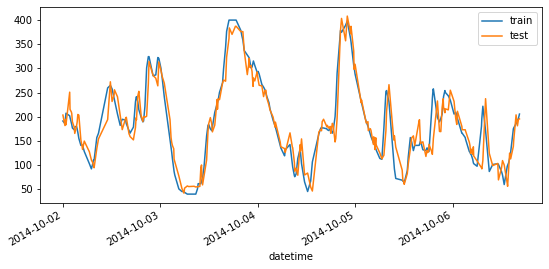

In [47]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
results['glucose'].plot(ax=ax, label='train')
results['predictions_rl'].plot(ax=ax, label='test')
ax.legend();

Como la raíz cuadrada de una varianza, RMSE se puede interpretar como la desviación estándar de la varianza inexplicada, y tiene la propiedad útil de estar en las mismas unidades que la variable de respuesta.

Los valores más bajos de RMSE indican un mejor ajuste. RMSE es una buena medida de la precisión con que el modelo predice la respuesta, y es el criterio más importante para ajustar si el propósito principal del modelo es la predicción.

In [57]:
df_p = p1.set_index('datetime')
df_p = df_p.asfreq(freq='5min', method="bfill")
df_p['hipoglucemia'] = [0 if i<=70 else 1 for i in df_p.glucose]
df_p = df_p[['hipoglucemia']]
df_p = df_p.sort_index()
df_p

,hipoglucemia
datetime,
2014-10-01 19:14:00,1
2014-10-01 19:19:00,1
2014-10-01 19:24:00,1
2014-10-01 19:29:00,1
2014-10-01 19:34:00,1
...,...
2014-10-06 16:34:00,1
2014-10-06 16:39:00,1
2014-10-06 16:44:00,1


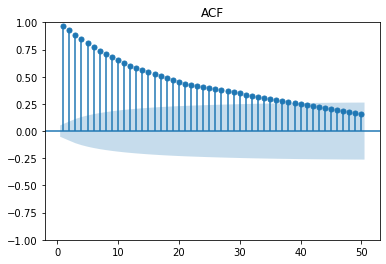

In [58]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(df_p, lags=50, zero=False)
plt.title("ACF")
plt.show()

In [59]:
df_p['lag10'] = df_p['hipoglucemia'].shift(10)
df_p['lag11'] = df_p['hipoglucemia'].shift(11)
df_p['lag12'] = df_p['hipoglucemia'].shift(12)
df_p['lag30'] = df_p['hipoglucemia'].shift(30)
df_p['lag35'] = df_p['hipoglucemia'].shift(35)
df_p.dropna(inplace=True)
df_p.head()

,hipoglucemia,lag10,lag11,lag12,lag30,lag35
datetime,,,,,,
2014-10-01 22:09:00,1,1.0,1.0,1.0,1.0,1.0
2014-10-01 22:14:00,1,1.0,1.0,1.0,1.0,1.0
2014-10-01 22:19:00,1,1.0,1.0,1.0,1.0,1.0
2014-10-01 22:24:00,1,1.0,1.0,1.0,1.0,1.0
2014-10-01 22:29:00,1,1.0,1.0,1.0,1.0,1.0


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = df_p[['lag10', 'lag11', 'lag12', 'lag30', 'lag35']], df_p['hipoglucemia']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [64]:
scaler = StandardScaler()
Scaled_train = scaler.fit_transform(X_train)

Scaled_test = scaler.transform(X_test)

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

reg = RandomForestRegressor(max_depth=10, random_state=0)
reg.fit(Scaled_train,y_train)

predictions_rf = reg.predict(Scaled_test)

results = pd.DataFrame(y_test)
results['predictions_rf'] = predictions_rf

rmse_rf = mean_squared_error(y_test, predictions_rf, squared=False)
results['rmse_rf'] = rmse_rf
results.head()

,hipoglucemia,predictions_rf,rmse_rf
datetime,,,
2014-10-03 23:54:00,1,0.968366,0.205706
2014-10-04 08:29:00,1,0.968366,0.205706
2014-10-06 03:59:00,1,0.968366,0.205706
2014-10-05 21:34:00,1,0.968366,0.205706
2014-10-04 00:19:00,1,0.968366,0.205706


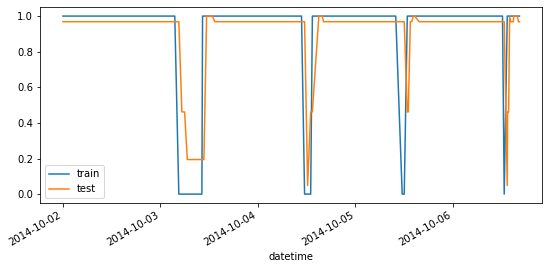

In [75]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
results['hipoglucemia'].plot(ax=ax, label='train')
results['predictions_rf'].plot(ax=ax, label='test')
ax.legend();

In [76]:
from sklearn.linear_model import LinearRegression
modelo = LinearRegression()
modelo.fit(Scaled_train, y_train)

predictions_rl = modelo.predict(Scaled_test)

results['predictions_rl'] = predictions_rl
rmse_rl = mean_squared_error(y_test, predictions_rl, squared=False)
results['rmse_rl'] = rmse_rl
results.head()



,hipoglucemia,predictions_rf,rmse_rf,predictions_rl,rmse_rl
datetime,,,,,
2014-10-03 23:54:00,1,0.968366,0.205706,0.972546,0.209122
2014-10-04 08:29:00,1,0.968366,0.205706,0.972546,0.209122
2014-10-06 03:59:00,1,0.968366,0.205706,0.972546,0.209122
2014-10-05 21:34:00,1,0.968366,0.205706,0.972546,0.209122
2014-10-04 00:19:00,1,0.968366,0.205706,0.972546,0.209122


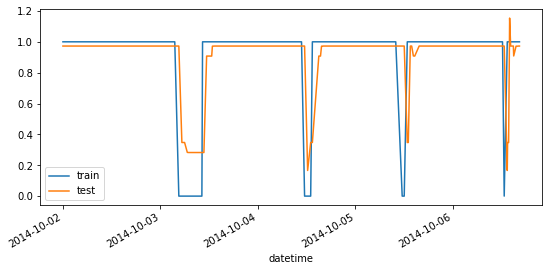

In [77]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
results['hipoglucemia'].plot(ax=ax, label='train')
results['predictions_rl'].plot(ax=ax, label='test')
ax.legend();